# Data Ingestion

In [2]:
import pandas as pd
import numpy as np

df_p1_elena = pd.read_csv('./data-cleanup/elena-may-1-kingston_clean.csv',parse_dates=True,index_col='ts').dropna()
di = {0: "Empty", 1: "Filling", 2: "Full"}

df_p1_elena = df_p1_elena.astype(
    {
        # "temp_rtc": float,
        "temp_am2320": float,
        "vbat_raw": int,
        "tank_raw": int,
        "float0": int,
        "float1": int,
        "float2": int,
        "float3": int,
        "bucket_mm_h": float,
        "tlq_level": int,
        "cistern_level": int
    }
)

# df_p1_elena = df_p1_elena.replace({"cistern_level": di, "tlq_level": di})

# df_p1_elena_rain = df_p1_elena.bucket_mm.resample('1h').sum()
df_p2_sylvia = pd.read_csv('./data/p2-sylvia-clean.csv',parse_dates=True,index_col='time')
df_p2_elena_cistern_level = pd.read_csv('./data/p2-elena-cistern-level.csv',parse_dates=True,index_col='time')
df_p2_elena_rain = pd.read_csv('./data/p2-elena-rain.csv',parse_dates=True,index_col='time')

df_weather = pd.read_csv('./data/open-meteo-quitelpec_0823-1024.csv', skiprows=3, index_col='time', parse_dates=True) 


# Data Processing

count rain volume at Elenas (36.2 m^2 roof area)

In [3]:
cum_rain_l = 0

sd = '2023-10-05-00:00'
ed = '2023-10-06-20:00'

# flag_

for i, row in df_p1_elena[sd:ed].iterrows():
    cum_rain_l += row["bucket_mm_h"]*36.2
    # if cum_rain_l > 200:
        

print(cum_rain_l)



1485.6480000000001


Map Elena pot value to cistern volume (P2). Assuming 10,000L cistern.

In [4]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(0,10000))

# print(scaler.fit(df_p2_elena_cistern_level))
# print(scaler.data_max_)

df_p2_elena_cistern_level['vol_L'] = scaler.fit_transform(df_p2_elena_cistern_level)

print(df_p2_elena_cistern_level['2024-06-12-06:00':'2024-06-14']['vol_L'])
df_p2_elena_cistern_level['2024-06-12':'2024-06-14']['vol_L'].idxmax()
# df_p2_elena_cistern_level['2024-06-12':'2024-06-14']['vol_L'].loc[8600]

time
2024-06-12 06:00:00      21.929825
2024-06-12 07:00:00      39.473684
2024-06-12 08:00:00      52.631579
2024-06-12 09:00:00      78.947368
2024-06-12 10:00:00      65.789474
                          ...     
2024-06-14 19:00:00    8017.543860
2024-06-14 20:00:00    8000.000000
2024-06-14 21:00:00    7982.456140
2024-06-14 22:00:00    7964.912281
2024-06-14 23:00:00    7940.058480
Name: vol_L, Length: 66, dtype: float64


Timestamp('2024-06-12 16:00:00')

Peak Detection

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

plt.rcParams['date.converter'] = 'concise'

WIN_WIDTH_HRS = 1
WIN_WIDTH = WIN_WIDTH_HRS*4*60

PEAK_DISTANCE_HRS = 24
PEAK_DISTANCE = PEAK_DISTANCE_HRS*4*60

PEAK_WIDTH_HRS = 0.5
PEAK_WIDTH = PEAK_WIDTH_HRS*4*60

# sd = '2023-08-01'
# ed = '2024-04-20'

sd = '2023-10-03-12:00'
ed = '2023-10-12-12:00'

sig = df_p1_elena.bucket_mm[sd:ed].to_numpy()
# sig = df_p1_elena.bucket_mm.to_numpy()

win = signal.windows.triang(WIN_WIDTH) 
filtered = signal.convolve(sig, win, mode='same') / sum(win)
peaks, peak_properties = signal.find_peaks(filtered, height=0, prominence=0, width=PEAK_WIDTH, distance=PEAK_DISTANCE)

print(f"TOTAL: {sig.sum()*36.2}\n--")



TOTAL: 2593.0060000000008
--


Rainfall event detection

In [34]:
type_rfe = {'peak': int, 'lb': int, 'rb': int, 'area': float}

rainfall_events = pd.DataFrame(data=None, columns=['peak','lb','rb','area'])

for i, peak in enumerate(peaks):
    lb = peak_properties['left_bases'][i]
    rb = peak_properties['right_bases'][i]
    area = filtered[lb:rb].sum()*36.2

    if (area > 200):
        row = pd.DataFrame([[peak,lb,rb,area]], columns=rainfall_events.columns)
        rainfall_events = pd.concat([rainfall_events,row],ignore_index=True)

rainfall_events = rainfall_events.astype(type_rfe)

rainfall_peaks = rainfall_events['peak'].values
rainfall_starts = rainfall_events['lb'].values
rainfall_ends = rainfall_events['rb'].values


# df_p1_elena['rain_filtered'] = filtered

# df_p1_elena['cum_sum_filtered'] = filtered.cumsum()
# df_p1_elena['cum_sum'] = sig




Tlaloque edge detection

In [35]:
def edge_find(data, thresh, kind=None):
    sign = data >= thresh
    if kind == 'rise':
        pos = np.where(np.convolve(sign, [1, -1]) == 1)
    elif kind == 'fall':
        pos = np.where(np.convolve(sign, [1, -1]) == -1)

    return pos[0]

filling_events = edge_find(df_p1_elena[sd:ed]['tlq_level'].values, 1.5, 'rise')
emptying_events = edge_find(df_p1_elena[sd:ed]['tlq_level'].values,1.5, 'fall')
# filling_events = edge_find(df_p1_elena['tlq_level'].values, 1.5, 'rise')
# emptying_events = edge_find(df_p1_elena['tlq_level'].values,5, 'fall')

Maintenance classification

In [36]:
length = len(df_p1_elena[sd:ed]) 
# length = len(df_p1_elena)
zeros = np.zeros((length,1))

# np_arr[filling_events]

df_events = pd.DataFrame(zeros, columns=['event'])

df_events['event'].iloc[rainfall_ends] = 'rain_end'
df_events['event'].iloc[rainfall_starts] = 'rain_start'
df_events['event'].iloc[filling_events] = 'filling'
df_events['event'].iloc[emptying_events] = 'emptying'
# df_events = df_events.astype({'rain_start': int, 'filling': int, 'emptying': int})

df_events = df_events[df_events['event'] != 0]

seq_good = np.array(['rain_start','filling','rain_end','emptying'])#,'rain_start'])
seq_bad = np.array(['rain_start','filling','rain_end','rain_start'])
# seq_bad = np.array(['rain_start','rain_end','rain_start','filling'])



# print(seq_good)

for i in range(0,len(df_events)):
    if (i < len(df_events) - 4) and df_events.iloc[i]['event'] == 'rain_start':
        # print((df_events[i:i+4]['event'].values))
        if (df_events[i:i+4]['event'].values == seq_bad).all():
            print(f"BAD sequence at {df_p1_elena[sd:ed].iloc[int(df_events.iloc[i].name)].name} to {df_p1_elena[sd:ed].iloc[int(df_events.iloc[i+4].name)].name}")
            
    if (i < len(df_events) - 4) and df_events.iloc[i]['event'] == 'rain_start':
        if (df_events[i:i+4]['event'].values == seq_good).all():
            print(f"GOOD sequence from {df_p1_elena[sd:ed].iloc[int(df_events.iloc[i].name)].name} to {df_p1_elena[sd:ed].iloc[int(df_events.iloc[i+4].name)].name}")
    

# df_events.plot()


GOOD sequence from 2023-10-03 20:33:15 to 2023-10-05 22:50:03
GOOD sequence from 2023-10-05 22:50:03 to 2023-10-08 17:49:14
GOOD sequence from 2023-10-08 17:49:14 to 2023-10-09 07:04:29


Nice plot

/var/folders/1v/vpz9zltd6k1319dwhgj1hcfw0000gp/T/ipykernel_14815/3632548892.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([0, 0.05, 0.1])
/var/folders/1v/vpz9zltd6k1319dwhgj1hcfw0000gp/T/ipykernel_14815/3632548892.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['Empty', 'Filling', 'Full'])


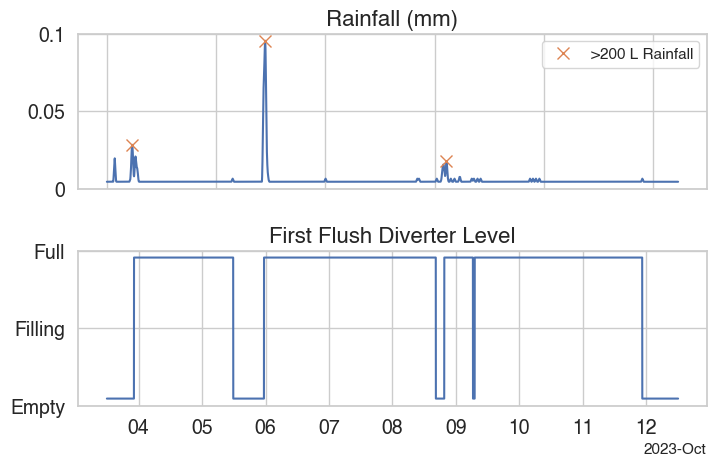

In [37]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.category import UnitData

plt.rcParams['date.converter'] = 'concise'
plt.rcParams['font.family'] = 'helvetica'

FONTSIZE_LABEL = 14
FONTSIZE_TITLE = 16

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7,4.5), gridspec_kw={'height_ratios': [1,1]})#, sharex=True)#, layout='constrained'))#, sharex=True)#, layout='constrained')


dummy = axs[0].plot(filtered)
# axs[0].plot(df_p1_elena[sd:ed].bucket_mm)
h_rainfall = axs[0].plot(rainfall_peaks, filtered[rainfall_peaks], "x", markersize=8, label='>200 L Rainfall')

# for i in range(0, len(rainfall_events)):
#     h_rainfall = axs[0].axvspan(rainfall_events.iloc[i]['lb'], rainfall_events.iloc[i]['rb'], color='orange', alpha=0.4, label=f'rainfall{i}')

# axs[0].vlines(rainfall_events['rb'],0,0.1,color='red')
# axs[0].vlines(rainfall_events['lb'],0,0.1,color='green')
axs[0].tick_params('x',labelbottom=False)
axs[0].tick_params('y', labelsize=FONTSIZE_LABEL)
axs[0].set_title('Rainfall (mm)',size=FONTSIZE_TITLE)
axs[0].yaxis.set_major_locator(ticker.LinearLocator(3))
axs[0].set_yticklabels([0, 0.05, 0.1])
axs[0].legend()
# axs[0].legend(handles=[h_rainfall],labels=['>200 L Rainfall'], fontsize=14)

axs[1].plot(df_p1_elena[sd:ed].index, df_p1_elena[sd:ed].tlq_level.values) #yunits=UnitData(['Empty', 'Filling', 'Full']))
# axs[1].vlines(filling_events,0,2,color='red')
# axs[1].vlines(emptying_events,0,2,color='orange')
axs[1].tick_params('x', labelsize=FONTSIZE_LABEL)
axs[1].tick_params('y', labelsize=FONTSIZE_LABEL)
# ax1.legend(['tlq','cist'])
axs[1].set_title('\nFirst Flush Diverter Level',size=FONTSIZE_TITLE)
axs[1].yaxis.set_major_locator(ticker.LinearLocator(3))
axs[1].set_yticklabels(['Empty', 'Filling', 'Full'])

plt.tight_layout(pad=0.1)

plt.savefig("plots/maintenance.svg")


Debugging plot

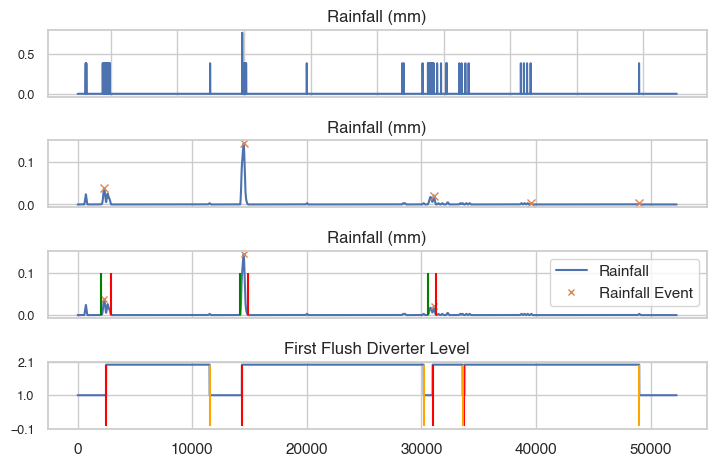

In [38]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.category import UnitData

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7,4.5), gridspec_kw={'height_ratios': [1,1,1,1]})#, layout='constrained'))#, sharex=True)#, layout='constrained')

plt.rcParams['date.converter'] = 'concise'

# ax1 = plt.subplot(311)
# axs[0].plot(df_p1_elena[sd:ed].index, df_p1_elena[sd:ed].bucket_mm)
axs[0].plot(df_p1_elena[sd:ed].index,sig)
# axs[0].plot(win)
axs[0].tick_params('x',labelbottom=False)
axs[0].tick_params('y', labelsize=9)
axs[0].set_title('Rainfall (mm)',size=12)

# axs[1].plot(df_p1_elena[sd:ed].index, filtered)#df_p1_elena[sd:ed].rain_filtered)
# axs[1].plot(df_p1_elena[sd:ed].index, filtered[peaks[0]], 'x')
axs[1].plot(filtered)
axs[1].plot(peaks, filtered[peaks], "x")
axs[1].tick_params('x',labelbottom=False)
axs[1].tick_params('y', labelsize=9)
axs[1].set_title('Rainfall (mm)',size=12)

# axs[2].plot(df_p1_elena[sd:ed].index, sig.cumsum())# df_p1_elena[sd:ed].cum_sum)
axs[2].plot(filtered)
axs[2].plot(rainfall_peaks, filtered[rainfall_peaks], "x", markersize=5)
axs[2].vlines(rainfall_events['rb'],0,0.1,color='red')
axs[2].vlines(rainfall_events['lb'],0,0.1,color='green')
axs[2].tick_params('x',labelbottom=False)
axs[2].tick_params('y', labelsize=9)
axs[2].set_title('Rainfall (mm)',size=12)
axs[2].legend(['Rainfall','Rainfall Event'])

# axs[3].plot(df_p1_elena[sd:ed].index, filtered.cumsum())#df_p1_elena[sd:ed].cum_sum_filtered)
# axs[3].plot(filtered.cumsum())
# axs[3].tick_params('x',labelbottom=False)
# axs[3].tick_params('y', labelsize=9)
# axs[3].set_title('Rainfall (mm)',size=12)

axs[3].plot(df_p1_elena[sd:ed].tlq_level.values) #yunits=UnitData(['Empty', 'Filling', 'Full']))
axs[3].vlines(filling_events,0,2,color='red')
axs[3].vlines(emptying_events,0,2,color='orange')
axs[3].tick_params('x')
axs[3].tick_params('y', labelsize=9)
# ax3.legend(['tlq','cist'])
axs[3].set_title('\nFirst Flush Diverter Level',size=12)
axs[3].yaxis.set_major_locator(ticker.LinearLocator(3))

plt.tight_layout(pad=0.1)

plt.savefig("plots/sensor_data_raw.pdf")


# Data Exploration

Going to try out IPython for ["rich" outputs](https://ipython.readthedocs.io/en/stable/interactive/plotting.html)

In [11]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Prototype 1 - Elena (08/23 - 04/24)

Data collection times

In [12]:
print("P1 - Elena")
print(f"Start: {df_p1_elena.iloc[0].name}")
print(f"Start: {df_p1_elena.iloc[len(df_p1_elena)-1].name}")
print(df_p1_elena.iloc[len(df_p1_elena)-1].name - df_p1_elena.iloc[0].name)

print("---\nP2 - Elena (LoRa Mesh)")
print("Cistern")
print(f"Start: {df_p2_elena_cistern_level.iloc[0].name}")
print(f"End: {df_p2_elena_cistern_level.iloc[len(df_p2_elena_cistern_level)-1].name}")
print(df_p2_elena_cistern_level.iloc[len(df_p2_elena_cistern_level)-1].name - df_p2_elena_cistern_level.iloc[0].name)
print("Rain")
print(f"Start: {df_p2_elena_rain.iloc[0].name}")
print(f"End: {df_p2_elena_rain.iloc[len(df_p2_elena_rain)-1].name}")
print(df_p2_elena_rain.iloc[len(df_p2_elena_rain)-1].name - df_p2_elena_rain.iloc[0].name)

print("---\nP2 - Sylvia (Lora Star)")
print("Cistern")
print(f"Start: {df_p2_sylvia.iloc[0].name}")
print(f"End: {df_p2_sylvia.iloc[len(df_p2_sylvia)-1].name}")
print(df_p2_sylvia.iloc[len(df_p2_sylvia)-1].name - df_p2_sylvia.iloc[0].name)
print("Rain")
s_rain = pd.Series(df_p2_sylvia['rain_count']).dropna()
print(s_rain.index[0])
print(f"Start: {s_rain.index[0]}")
print(f"End: {s_rain.index[len(s_rain)-1]}")
print(s_rain.index[len(s_rain)-1] - s_rain.index[0])




P1 - Elena
Start: 2023-08-18 18:39:30
Start: 2024-04-19 12:59:45
244 days 18:20:15
---
P2 - Elena (LoRa Mesh)
Cistern
Start: 2024-05-29 13:00:00
End: 2024-08-26 16:00:00
89 days 03:00:00
Rain
Start: 2024-05-29 14:00:00
End: 2024-09-21 03:00:00
114 days 13:00:00
---
P2 - Sylvia (Lora Star)
Cistern
Start: 2024-05-20 01:39:40
End: 2024-09-05 05:34:05
108 days 03:54:25
Rain
2024-05-20 04:09:07
Start: 2024-05-20 04:09:07
End: 2024-08-15 11:42:06
87 days 07:32:59


### Plotting All Data

Text(0.5, 1.0, 'Cistern Levels')

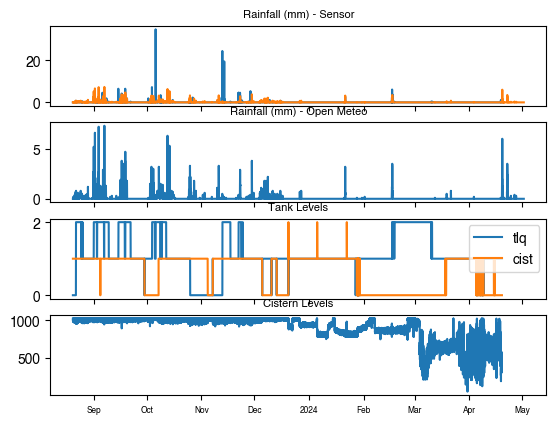

In [13]:
sd = '2023-08-20'
ed = '2024-05-01'

# df_weather_p1 = df_weather[sd:ed]

ax1 = plt.subplot(411)
plt.plot(df_p1_elena[sd:ed].index, df_p1_elena[sd:ed].bucket_mm_h, df_weather[sd:ed].rain_mm)
plt.tick_params('x',labelbottom=False)
plt.title('Rainfall (mm) - Sensor',size=8)

ax2 = plt.subplot(412, sharex=ax1)
plt.plot(df_weather[sd:ed].index, df_weather[sd:ed].rain_mm) #, df_weather_p1[sd:ed].rain_mm)
plt.tick_params('x',labelbottom=False)
plt.title('Rainfall (mm) - Open Meteo',size=8)


ax3 = plt.subplot(413,sharex=ax1)
plt.plot(df_p1_elena[sd:ed].index, df_p1_elena[sd:ed].tlq_level, df_p1_elena[sd:ed].cistern_level)
plt.tick_params('x',labelbottom=False)
ax3.legend(['tlq','cist'])
plt.title('Tank Levels',size=8)

ax4 = plt.subplot(414,sharex=ax1)
plt.plot(df_p1_elena[sd:ed].index, df_p1_elena[sd:ed].tank_raw)
plt.tick_params('x',labelsize=6)
plt.title('Cistern Levels', size=8)


### Plotting Data (w/o pot)

/var/folders/1v/vpz9zltd6k1319dwhgj1hcfw0000gp/T/ipykernel_14815/412201857.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['Empty','Filling','Full'])
/var/folders/1v/vpz9zltd6k1319dwhgj1hcfw0000gp/T/ipykernel_14815/412201857.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels(['Empty','Filling','Full'])


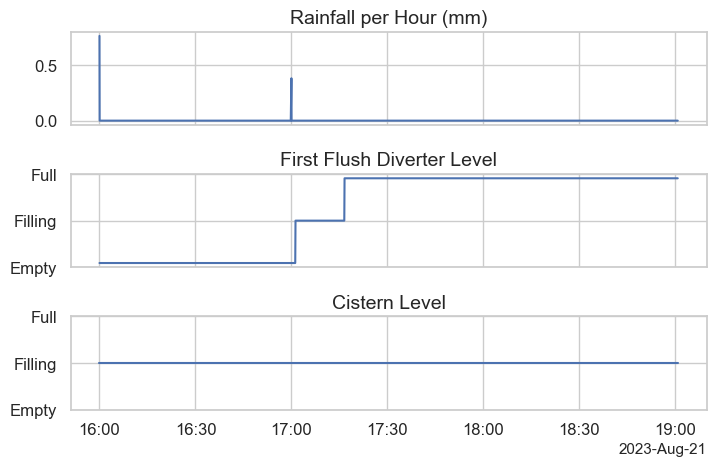

In [42]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.category import UnitData
import seaborn as sns

sns.set_theme(style='whitegrid')

FONTSIZE_LABEL = 12
FONTSIZE_TITLE = 14


sd = '2023-08-21-16:00'
ed = '2023-08-21-19:00'

# sd = '2023-9-14-12:00'
# ed = '2023-9-17-12:00'

fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(7,4.5))#, layout='constrained')

plt.rcParams['date.converter'] = 'concise'

# ax1 = plt.subplot(311)
axs[0].plot(df_p1_elena[sd:ed].index, df_p1_elena[sd:ed].bucket_mm_h)
axs[0].tick_params('x',labelbottom=False)
axs[0].tick_params('y', labelsize=FONTSIZE_LABEL)
axs[0].set_title('Rainfall per Hour (mm)',size=FONTSIZE_TITLE)

# ax3 = plt.subplot(311,sharex=ax1)
axs[1].plot(df_p1_elena[sd:ed].index, df_p1_elena[sd:ed].tlq_level, yunits=UnitData(['Empty', 'Filling', 'Full']))
axs[1].tick_params('x',labelbottom=False)
axs[1].tick_params('y', labelsize=FONTSIZE_LABEL)
# ax3.legend(['tlq','cist'])
axs[1].set_title('\nFirst Flush Diverter Level',size=FONTSIZE_TITLE)
axs[1].yaxis.set_major_locator(ticker.LinearLocator(3))
axs[1].set_yticklabels(['Empty','Filling','Full'])

# ax4 = plt.subplot(213,sharex=ax1)
axs[2].plot(df_p1_elena[sd:ed].index, df_p1_elena[sd:ed].cistern_level)#, yunits=UnitData(['Empty', 'Filling', 'Full']))
axs[2].tick_params('x',labelsize=FONTSIZE_LABEL)
axs[2].tick_params('y', labelsize=FONTSIZE_LABEL)
axs[2].yaxis.set_major_locator(ticker.LinearLocator(3))
axs[2].set_yticklabels(['Empty','Filling','Full'])
axs[2].set_title('Cistern Level', size=FONTSIZE_TITLE)

# axs[3].xaxis.set_major_locator(mdates.MonthLocator(bymonth=np.arange(1, 13, 1)))
# axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))

plt.tight_layout(pad=0.1)

plt.savefig("plots/sensor_data_raw.pdf")

plt.show()


/var/folders/1v/vpz9zltd6k1319dwhgj1hcfw0000gp/T/ipykernel_14815/4161656195.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['Empty','Filling','Full'])


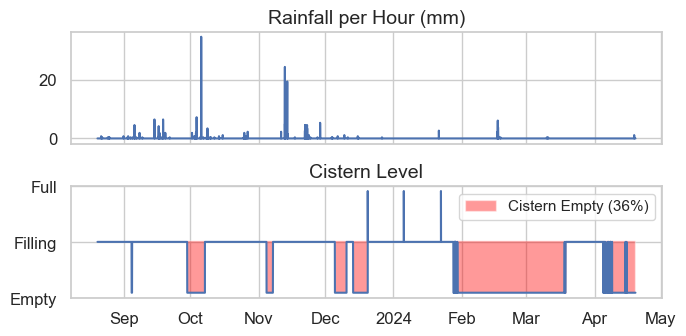

In [15]:


fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7,3.5), gridspec_kw={'height_ratios': [1, 1]})#, layout='constrained')

plt.rcParams['date.converter'] = 'concise'

# ax1 = plt.subplot(311)
axs[0].plot(df_p1_elena[sd:ed].index, df_p1_elena[sd:ed].bucket_mm_h)
axs[0].tick_params('x',labelbottom=False)
axs[0].tick_params('y', labelsize=FONTSIZE_LABEL)
axs[0].set_title('Rainfall per Hour (mm)',size=FONTSIZE_TITLE)

# ax4 = plt.subplot(313,sharex=ax1)
axs[1].plot(df_p1_elena[sd:ed].index, df_p1_elena[sd:ed].cistern_level)#, yunits=UnitData(['Empty', 'Filling', 'Full']))
axs[1].fill_between(df_p1_elena[sd:ed].index, 1.02, where=df_p1_elena[sd:ed].cistern_level < 1, facecolor='red', alpha=.4, label='Cistern Empty (36%)')
# axs[1].fill_between(df_p1_elena[sd:ed].index, 2, where=df_p1_elena[sd:ed].cistern_level > 0, facecolor='green', alpha=.5)
axs[1].tick_params('x',labelsize=FONTSIZE_LABEL)
axs[1].tick_params('y', labelsize=FONTSIZE_LABEL)
axs[1].yaxis.set_major_locator(ticker.LinearLocator(3))
axs[1].set_yticklabels(['Empty','Filling','Full'])
axs[1].set_title('Cistern Level', size=FONTSIZE_TITLE)
axs[1].legend()


# axs[1].xaxis.set_major_locator(mdates.MonthLocator(bymonth=np.arange(1, 13, 1)))
# axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))

plt.tight_layout(pad=1)

plt.savefig("plots/empty_cistern.pdf")

plt.show()


## Prototype 2 - Elena ()

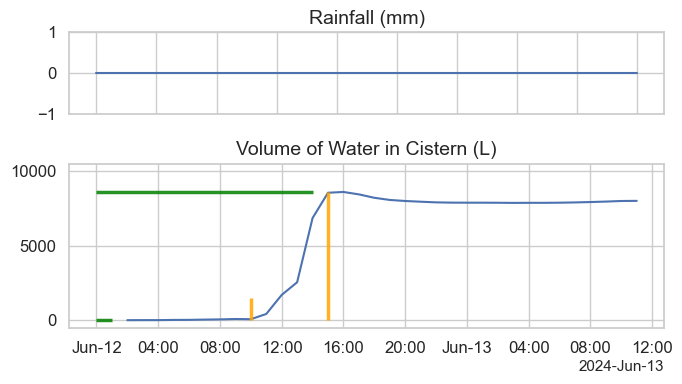

In [16]:
start_date = '2024-06-12-00:00'
end_date = '2024-06-13-12:00'

# start_date = '2024-05-01'
# end_date = '2024-12-31'


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7,4), gridspec_kw={'height_ratios': [1, 2]})#, layout='constrained')

axs[0].plot(df_p2_elena_rain[start_date:end_date].index, df_p2_elena_rain[start_date:end_date].bucket_mm) #, df_weather[start_date:end_date].rain_mm)
axs[0].tick_params('x',labelbottom=False)
axs[0].tick_params('y', labelsize=FONTSIZE_LABEL)
axs[0].set_title('Rainfall (mm)',size=FONTSIZE_TITLE)
# axs[0].set_ylabel('Rainfall (mm)',size=12)
axs[0].set_ylim([-1,1])
axs[0].yaxis.set_major_locator(ticker.LinearLocator(3))

# ax2 = plt.subplot(312,sharex=ax1)
# plt.plot(df_p2_elena_rain[start_date:end_date].index, df_p2_elena_rain[start_date:end_date].bucket_mm)
# plt.plot(df_weather[start_date:end_date].index, df_weather[start_date:end_date].rain_mm)
# plt.tick_params('x',labelbottom=False)
# plt.title('Rainfall - Open Meteo',size=8)
LW = 2.5

axs[1].plot(df_p2_elena_cistern_level[start_date:end_date].index[2:-1], df_p2_elena_cistern_level[start_date:end_date].vol_L[2:-1], '-')
axs[1].tick_params('x',labelsize=FONTSIZE_LABEL)
axs[1].tick_params('y',labelsize=FONTSIZE_LABEL)
# axs[1].set_ylabel('Water Volume in Tank (L)')
axs[1].set_title('Volume of Water in Cistern (L)',size=FONTSIZE_TITLE)
# axs[1].axvspan(df_p2_elena_cistern_level[start_date:end_date].index[14], df_p2_elena_cistern_level[start_date:end_date].index[18], color='orange', alpha=0.4)
axs[1].vlines([df_p2_elena_cistern_level[start_date:end_date].index[10]],0, 1500, color='orange',linewidth=LW, alpha=.85)
axs[1].vlines(df_p2_elena_cistern_level[start_date:end_date].index[15],0, 8600, color='orange',linewidth=LW, alpha=.85)
axs[1].hlines(8600, df_p2_elena_cistern_level[start_date:end_date].index[0], df_p2_elena_cistern_level[start_date:end_date].index[14], color='green', linewidth=LW, alpha=.85)
axs[1].hlines(0, df_p2_elena_cistern_level[start_date:end_date].index[0], df_p2_elena_cistern_level[start_date:end_date].index[1], color='green', linewidth=LW, alpha=.85)
# axs[1].vlines()
# axs[1].fill([100,100],[1000,1000])

# axs[1].yaxis.set_major_locator(ticker.LinearLocator(6))
axs[1].set_ylim([-500,10500])

plt.tight_layout()

plt.savefig("plots/cistern-filling.svg")

plt.show()

## Prototype 2 - Sylvia ()

Text(0.5, 1.0, 'Rain gauge')

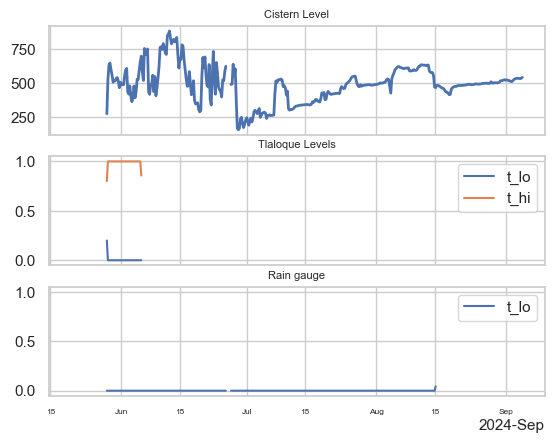

In [17]:
start_date = '2024-05-01'
end_date = '2024-11-30'

df_p2_sylvia = df_p2_sylvia.resample('6h').mean()

ax1 = plt.subplot(311)
plt.plot(df_p2_sylvia[start_date:end_date].index, df_p2_sylvia[start_date:end_date].pot, '-', linewidth=2, markersize=2)
plt.tick_params('x',labelbottom=False)
plt.title('Cistern Level',size=8)

ax2 = plt.subplot(312,sharex=ax1)
plt.plot(df_p2_sylvia[start_date:end_date].index, df_p2_sylvia[start_date:end_date].t_lvl_lo, '-', df_p2_sylvia[start_date:end_date].t_lvl_hi, '-', markersize=1)
ax2.legend(['t_lo','t_hi'])
plt.tick_params('x',labelbottom=False, labelsize=6)
plt.title('Tlaloque Levels',size=8)

ax2 = plt.subplot(313,sharex=ax1)
plt.plot(df_p2_sylvia[start_date:end_date].index, df_p2_sylvia[start_date:end_date].rain_count, '-')
ax2.legend(['t_lo','t_hi'])
plt.tick_params('x',labelsize=6)
plt.title('Rain gauge', size=8)

